In [1]:
!pip install statsmodels==0.12.1

     |████████████████████████████████| 9.5 MB 6.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
!pip install arch

     |████████████████████████████████| 902 kB 7.4 MB/s 


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import requests
import re
import os
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from arch import arch_model

In [4]:
###### use this to get current list of links:
# req = requests.get('https://download.bls.gov/pub/time.series/cu/')
# soup = bs(req.text)

# links = []
# for link in soup.findAll('a'):
#     print(link.get('href'))

list_of_links = [
# '/pub/time.series/cu/cu.data.1.AllItems',
'/pub/time.series/cu/cu.data.11.USFoodBeverage',
'/pub/time.series/cu/cu.data.12.USHousing',
'/pub/time.series/cu/cu.data.13.USApparel',
'/pub/time.series/cu/cu.data.14.USTransportation',
'/pub/time.series/cu/cu.data.15.USMedical',
'/pub/time.series/cu/cu.data.16.USRecreation',
'/pub/time.series/cu/cu.data.17.USEducationAndCommunication',
'/pub/time.series/cu/cu.data.18.USOtherGoodsAndServices',
'/pub/time.series/cu/cu.data.20.USCommoditiesServicesSpecial',
]

all_items = pd.DataFrame()

for link in list_of_links:
    #all timeseries data from bls.
    sub_dataset = pd.read_csv(f'https://download.bls.gov{link}', sep='\t')
    sub_dataset = sub_dataset.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    sub_dataset.columns = [x.strip() for x in sub_dataset.columns]

    all_items = pd.concat([all_items, sub_dataset], axis=0)

In [5]:
#series description or meta information data from bls.
series_descriptions = pd.read_csv('https://download.bls.gov/pub/time.series/cu/cu.series', sep='\t')
series_descriptions = series_descriptions.applymap(lambda x: x.strip() if isinstance(x, str) else x)
series_descriptions.columns = [x.strip() for x in series_descriptions.columns]

#period description from bls.
period_description = pd.read_csv('https://download.bls.gov/pub/time.series/cu/cu.period', sep='\t')
period_description = period_description.applymap(lambda x: x.strip() if isinstance(x, str) else x)
period_description.columns = [x.strip() for x in period_description.columns]

# periodicity desciption from BLS, monthly, or other. We only care about monthly.
periodicity_description = pd.read_csv('https://download.bls.gov/pub/time.series/cu/cu.periodicity', sep='\t')
periodicity_description = periodicity_description.applymap(lambda x: x.strip() if isinstance(x, str) else x)
periodicity_description.columns = [x.strip() for x in periodicity_description.columns]

# seasonallity description from BLS, if data is seasonally adjusted or not.
seasonal_description = pd.read_csv('https://download.bls.gov/pub/time.series/cu/cu.seasonal', sep='\t')
seasonal_description = seasonal_description.applymap(lambda x: x.strip() if isinstance(x, str) else x)
seasonal_description.columns = [x.strip() for x in seasonal_description.columns]

In [6]:
#enhance timeseries data with meta data located in other files.
all_items_enhanced = all_items.merge(series_descriptions, how='left',  left_on='series_id', right_on='series_id')
all_items_enhanced = all_items_enhanced.merge(period_description, how='left',  left_on='period', right_on='period')
all_items_enhanced = all_items_enhanced.merge(periodicity_description, how='left',  left_on='periodicity_code', right_on='periodicity_code')
all_items_enhanced = all_items_enhanced.merge(seasonal_description, how='left',  left_on='seasonal', right_on='seasonal_code')

In [7]:
# 1. filter to only the monthly data. 
# 2. add a datetime column
# 3. sort rows by dates. 
# 4. set multi-index to series_id and date for easy access. 

periods_wanted = [ 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December' ]
all_items_enhanced = all_items_enhanced[ all_items_enhanced.period_name.isin(periods_wanted)].reset_index()
all_items_enhanced['date'] = pd.to_datetime(all_items_enhanced['period'].str[-2:] + '/' +  all_items_enhanced['year'].astype(str), format='%m/%Y') + pd.offsets.MonthEnd(0)
all_items_enhanced = all_items_enhanced.sort_values('date')
all_items_enhanced = all_items_enhanced.set_index(['series_id', 'date'])

all_items_enhanced.to_pickle('all_items_enhanced.pickle')
all_items_enhanced.to_csv('all_items_enhanced.csv')
# series_descriptions.to_csv('series_descriptions.csv')

In [8]:
all_timeseries_data = pd.read_pickle('all_items_enhanced.pickle')
all_timeseries_data.tail()

,,index,year,period,value,footnote_codes_x,area_code,item_code,seasonal,periodicity_code,base_code,...,footnote_codes_y,begin_year,begin_period,end_year,end_period,period_abbr,period_name,periodicity_name,seasonal_code,seasonal_text
series_id,date,,,,,,,,,,,,,,,,,,,,,
CUUR0000SERC02,2022-03-31,314646,2022,M03,86.446,NaN,0000,SERC02,U,R,S,...,NaN,1978,M01,2022,M03,MAR,March,Monthly,U,Not Seasonally Adjusted
CUURN000SAS4,2022-03-31,419103,2022,M03,195.059,NaN,N000,SAS4,U,R,S,...,NaN,1997,M12,2022,M03,MAR,March,Monthly,U,Not Seasonally Adjusted
CUUR0000SEHH03,2022-03-31,175610,2022,M03,44.231,NaN,0000,SEHH03,U,R,S,...,NaN,1997,M12,2022,M03,MAR,March,Monthly,U,Not Seasonally Adjusted
CUUR0000SEFT06,2022-03-31,103484,2022,M03,150.805,NaN,0000,SEFT06,U,R,S,...,NaN,1997,M12,2022,M03,MAR,March,Monthly,U,Not Seasonally Adjusted
CUURS000SASLE,2022-03-31,431977,2022,M03,311.627,NaN,S000,SASLE,U,R,S,...,NaN,1986,M12,2022,M03,MAR,March,Monthly,U,Not Seasonally Adjusted


In [9]:
#timeseries we care about
series_ids = {
    'CUUR0000SA0': '1. All Items',
    
    'CUUR0000SAF1': '1.1 Food',
        'CUUR0000SAF11': '1.1.1 Food at Home',
            'CUUR0000SAF112': '1.1.1.1 Meats, poultry, fish, and eggs',
            'CUUR0000SAF113': '1.1.1.2 Fruits and vegetables',
            'CUUR0000SAF111': '1.1.1.3 Cereals and bakery products',

        'CUUR0000SEFV': '1.1.2 Food away from Home',
            'CUUR0000SEFV02': '1.1.2.1 Limited service meals and snacks',
            'CUUR0000SEFV01': '1.1.2.1 Full service meals and snacks',

    'CUUR0000SA0E': '1.2 Energy',
        'CUUR0000SACE': '1.2.1 Energy Commodities',
        'CUUR0000SEHF': '1.2.2 Energy Services',

    'CUUR0000SA0L1E': '1.3 All items less food and energy',
        'CUUR0000SACL1E': '1.3.1 Commodities less food and energy commodities',
            'CUUR0000SATCLTB': '1.3.1.1 Transportation commodities less motor fuel',
            'CUUR0000SAH31': '1.3.1.2 Household furnishings and supplies',
            'CUUR0000SAA': '1.3.1.3 Apparel',

        'CUUR0000SASLE': '1.3.2 Services less energy services',
            'CUUR0000SAH1': '1.3.2.1 Shelter',
            'CUUR0000SAM2': '1.3.2.2 Medical care services',
            'CUUR0000SAS4': '1.3.2.3 Transportation services',
            'CUUR0000SAES': '1.3.2.4 Education and communication services',
            'CUUR0000SARS': '1.3.2.5 Recreation services'
}

for id in series_ids:

    columns_we_care_about = ['series_title', 'value']
    sub_series = all_timeseries_data.xs(id, level='series_id')[columns_we_care_about].copy()
    sub_series['yoy_inflation_rate'] = sub_series['value'].pct_change(12)
    sub_series['mom_inflation_rate'] = sub_series['value'].pct_change(1)

    sub_series.to_pickle(f'{series_ids[id]}.pickle')
    # sub_series.to_csv(f'{series_ids[id]}.csv')

#https://www.bls.gov/news.release/cpi.nr0.htm
#https://www.bls.gov/cpi/tables/relative-importance/2021.htm

#most recent weights and values two main rollups
# https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fwww.bls.gov%2Fcpi%2Ftables%2Fsupplemental-files%2Fnews-release-table1-202202.xlsx&wdOrigin=BROWSELINK
# https://view.officeapps.live.com/op/view.aspx?src=https%3A%2F%2Fwww.bls.gov%2Fcpi%2Ftables%2Fsupplemental-files%2Fnews-release-table2-202202.xlsx&wdOrig

In [10]:
file_name = '1. All Items'
all_items = pd.read_pickle(f'{file_name}.pickle')
all_items.tail()

,series_title,value,yoy_inflation_rate,mom_inflation_rate
date,,,,
2021-11-30,"All items in U.S. city average, all urban cons...",277.948,0.068090,0.004913
2021-12-31,"All items in U.S. city average, all urban cons...",278.802,0.070364,0.003073
2022-01-31,"All items in U.S. city average, all urban cons...",281.148,0.074799,0.008415
2022-02-28,"All items in U.S. city average, all urban cons...",283.716,0.078711,0.009134
2022-03-31,"All items in U.S. city average, all urban cons...",287.504,0.085425,0.013351


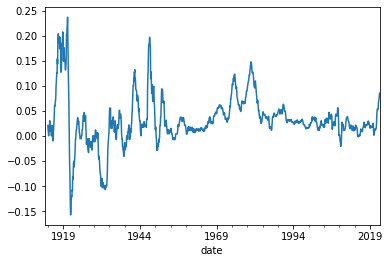

In [11]:
all_items['yoy_inflation_rate'].plot()

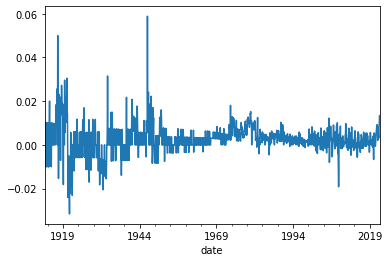

In [ ]:
all_items['mom_inflation_rate'].plot()

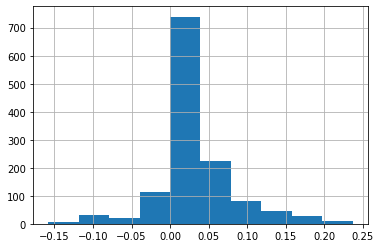

In [12]:
all_items['yoy_inflation_rate'].hist()

In [13]:
class gen_operation_series():

    series_name = ""
    df_series_data = pd.DataFrame()

    def __init__(self, series_name):
        self.series_name = ' '.join(series_name.split(" ")[1:])
        self.df_series_data = pd.read_pickle(f'{series_name}.pickle')

    def get_series_min_date(self):
        return self.df_series_data.index.min()

    def get_series_max_date(self):
        return self.df_series_data.index.max()

    def read_top_n_records(self, top_n = 5):
        print(f"Printing {top_n} records for the series {self.series_name}...")
        print(self.df_series_data.head(top_n))

    def read_bottom_n_records(self, bottom_n = 5):
        print(f"Printing {bottom_n} records for the series {self.series_name}...")
        print(self.df_series_data.head(bottom_n))

    def get_dist_info(self, col_name = None, from_year = None, to_year = None):
        print(f"Series Name = {self.series_name}, Column = {col_name}, from year = {from_year}, to year = {to_year}")
        if col_name == None and from_year == None and to_year == None:
            #print("a")
            print(self.df_series_data.describe())
        elif col_name == None and from_year is not None and to_year == None:
            #print("b")
            print(self.df_series_data[(self.df_series_data.index.year >= from_year)].describe())
        elif col_name == None and from_year == None and to_year is not None:
            #print("c")
            print(self.df_series_data[(self.df_series_data.index.year <= to_year)].describe())  
        elif col_name == None and from_year is not None and to_year is not None:
            #print("d")
            print(self.df_series_data[(self.df_series_data.index.year >= from_year) & (self.df_series_data.index.year <= to_year)].describe())  
        elif col_name is not None and from_year == None and to_year == None:
            #print("e")
            print(self.df_series_data[col_name].describe())
        elif col_name is not None and from_year is not None and to_year == None:
            #print("f")
            print(self.df_series_data[(self.df_series_data.index.year >= from_year)][col_name].describe())
        elif col_name is not None and from_year == None and to_year is not None:
            #print("g")
            print(self.df_series_data[(self.df_series_data.index.year <= to_year)][col_name].describe())  
        elif col_name is not None and from_year is not None and to_year is not None:
            #print("h")
            print(self.df_series_data[(self.df_series_data.index.year >= from_year) & (self.df_series_data.index.year <= to_year)][col_name].describe())  
    
    def __str__(self):
        return f"{self.series_name} has {len(self.df_series_data)} records between {self.df_series_data.index.min()} and {self.df_series_data.index.max()} dates"

    def __repr__(self):
        return f"{self.series_name} has {len(self.df_series_data)} records between {self.df_series_data.index.min()} and {self.df_series_data.index.max()} dates"

In [14]:
class visualize_series(gen_operation_series):

    series_name = ""
    df_series_data = pd.DataFrame()

    def __init__(self, series_name):
        gen_operation_series.__init__(self, series_name)

    def get_series_min_date(self):
        return gen_operation_series.get_series_min_date(self)

    def get_series_max_date(self):
        return gen_operation_series.get_series_max_date(self)

    def read_top_n_records(self, top_n = 5):
        gen_operation_series.read_top_n_records(self, top_n)

    def read_bottom_n_records(self, bottom_n = 5):
        gen_operation_series.read_bottom_n_records(self, bottom_n)
    
    def get_dist_info(self, col_name = None, from_year = None, to_year = None):
        gen_operation_series.get_dist_info(self, col_name, from_year, to_year)
    
    def line_plot_data(self, col_name, color = 'black', ref_df = all_items):
        #print(f"Line plot for {col_name} for the series {self.series_name}...")
        fig, ax  = plt.subplots(1,1, figsize=(10, 8))
        fig.align_labels()
        plt_title = f"Line plot for {col_name} for the series {self.series_name}"
        self.df_series_data[col_name].plot(ax = ax, color = color, label = 'YoY for ' + self.series_name)  
        ref_df[col_name].plot(ax = ax, color = 'blue', label = 'YoY for all items')
        ax.axhline(y=0, color='green', linewidth=4)
        plt.title(plt_title)
        ax.set_xlabel("Year")
        ax.set_ylabel(f"Fluctuation of {col_name} in {self.series_name}" )
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.show()

    def hist_plot(self, col_name, from_year = None, to_year = None):
        plt.figure(figsize = (10,5))
        if from_year is None and to_year is None:
            #print(f"Histogram plot for {col_name} for the series {self.series_name}...")
            plt_title = "Histogram plot for {col_name} for the series {self.series_name}"
            self.df_series_data[col_name].hist()
        elif from_year is not None and to_year is None:
            #print(f"Histogram plot for {col_name} for the series {self.series_name} from the year {from_year}...")
            plt_title = f"Histogram plot for {col_name} for the series {self.series_name} from the year {from_year}"
            self.df_series_data[(self.df_series_data.index.year >= from_year)][col_name].hist()
        elif from_year is not None and to_year is not None:
            #print(f"Histogram plot for {col_name} for the series {self.series_name} between the year {from_year} and {to_year}...")
            plt_title = f"Histogram plot for {col_name} for the series {self.series_name} between the year {from_year} and {to_year}"
            self.df_series_data[(self.df_series_data.index.year >= from_year) & (self.df_series_data.index.year <= to_year)][col_name].hist()
        elif from_year is None and to_year is not None:
            #print(f"Histogram plot for {col_name} for the series {self.series_name} till the year {to_year}...")
            plt_tile = f"Histogram plot for {col_name} for the series {self.series_name} till the year {to_year}"
            self.df_series_data[(self.df_series_data.index.year <= from_year)][col_name].hist()
        plt.title(plt_title)   
        plt.show()

    def __str__(self):
        return f"{self.series_name} has {len(self.df_series_data)} records between {self.df_series_data.index.min()} and {self.df_series_data.index.max()} dates"

    def __repr__(self):
        return f"{self.series_name} has {len(self.df_series_data)} records between {self.df_series_data.index.min()} and {self.df_series_data.index.max()} dates"


In [15]:
class statistical_analysis(gen_operation_series):

    series_name = ""
    df_series_data = pd.DataFrame()
    df_series_data_with_trend_seasonality_ver_1 = pd.DataFrame()
    df_series_data_with_trend_seasonality_ver_2 = pd.DataFrame()

    def __init__(self, series_name):
        self.series_name = series_name
        self.df_series_data = pd.read_pickle(f'{self.series_name}.pickle')

    def read_top_n_records(self, top_n = 5):
        print(f"Printing {top_n} records of the series {self.series_name}...")
        print(self.df_series_data.head(top_n))

    def read_bottom_n_records(self, bottom_n = 5):
        print(f"Printing {bottom_n} records of the series {self.series_name}...")
        print(self.df_series_data.head(bottom_n))
    
    def seasonal_decompose(self, col_name):
        print(f"Seasonal decompose the series {self.series_name}...")
        temp_df = self.df_series_data[col_name].dropna()
        result = seasonal_decompose(temp_df)
        result.plot()
        plt.show()
        
        if len(self.df_series_data_with_trend_seasonality_ver_1) == 0:
            self.df_series_data_with_trend_seasonality_ver_1 = pd.concat([result.seasonal, result.trend, result.resid, result.observed], axis=1)
            self.df_series_data_with_trend_seasonality_ver_1.columns = ['seas', 'trend', 'resid', 'actual_values']
            self.df_series_data_with_trend_seasonality_ver_1 = self.df_series_data_with_trend_seasonality_ver_1[['seas', 'trend', 'resid', 'actual_values']]
            self.df_series_data_with_trend_seasonality_ver_1['col_name'] = col_name
        else:
            temp = pd.concat([result.seasonal, result.trend, result.resid, result.observed], axis=1)
            temp.columns = ['seas', 'trend', 'resid', 'actual_values']
            temp['col_name'] = col_name
            self.df_series_data_with_trend_seasonality_ver_1 = pd.concat([self.df_series_data_with_trend_seasonality_ver_1, temp])
            self.df_series_data_with_trend_seasonality_ver_1.columns = ['seas', 'trend', 'resid', 'actual_values', 'col_name']
        
        print(self.df_series_data_with_trend_seasonality_ver_1)

    def STL(self, col_name):
        print(f"STL the series {self.series_name}...")
        temp_df = self.df_series_data[col_name].dropna()
        stl = STL(temp_df, period=12, robust=True,)
        result = stl.fit()
        result.plot()
        plt.show()
        
        if len(self.df_series_data_with_trend_seasonality_ver_2) == 0:
            self.df_series_data_with_trend_seasonality_ver_2 = pd.concat([result.seasonal, result.trend, result.resid, result.observed], axis=1)
            self.df_series_data_with_trend_seasonality_ver_2.columns = ['seas', 'trend', 'resid', 'actual_values']
            self.df_series_data_with_trend_seasonality_ver_2 = self.df_series_data_with_trend_seasonality_ver_2[['seas', 'trend', 'resid', 'actual_values']]
            self.df_series_data_with_trend_seasonality_ver_2['col_name'] = col_name
        else:
            temp = pd.concat([result.seasonal, result.trend, result.resid, result.observed], axis=1)
            temp.columns = ['seas', 'trend', 'resid', 'actual_values']
            temp['col_name'] = col_name
            self.df_series_data_with_trend_seasonality_ver_2 = pd.concat([self.df_series_data_with_trend_seasonality_ver_2, temp])
            self.df_series_data_with_trend_seasonality_ver_2.columns = ['seas', 'trend', 'resid', 'actual_values', 'col_name']
        
        print(self.df_series_data_with_trend_seasonality_ver_2)        

    def stationarity_test_adf(self, col_name):
        print(f"Stationarity test the series {self.series_name}...")
        temp_df = self.df_series_data[col_name].dropna()
        result = adfuller(temp_df)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
	          print('\t%s: %.3f' % (key, value))
        if result[1] < .05:
            print(f"Data with {col_name} is stationary, Null Hypothesis (H0) rejected, the data does not have a unit root and is stationary")
        else:
            print(f"Data with {col_name} is not stationary, Null Hypothesis(H1) accepted, the data has a unit root and is non-stationary.")

    def __str__(self):
        return f"{self.series_name} has {len(self.df_series_data)} records"

    def __repr__(self):
        return f"{self.series_name} has {len(self.df_series_data)} records"


['1.3 All items less food and energy', '1.3.1 Commodities less food and energy commodities', '1.3.1.1 Transportation commodities less motor fuel', '1.3.1.2 Household furnishings and supplies', '1.3.1.3 Apparel', '1.3.2 Services less energy services', '1.3.2.1 Shelter', '1.3.2.2 Medical care services', '1.3.2.3 Transportation services', '1.3.2.4 Education and communication services', '1.3.2.5 Recreation services']
[All items less food and energy has 783 records between 1957-01-31 00:00:00 and 2022-03-31 00:00:00 dates, Commodities less food and energy commodities has 783 records between 1957-01-31 00:00:00 and 2022-03-31 00:00:00 dates, Transportation commodities less motor fuel has 148 records between 2009-12-31 00:00:00 and 2022-03-31 00:00:00 dates, Household furnishings and supplies has 148 records between 2009-12-31 00:00:00 and 2022-03-31 00:00:00 dates, Apparel has 1045 records between 1914-12-31 00:00:00 and 2022-03-31 00:00:00 dates, Services less energy services has 783 record

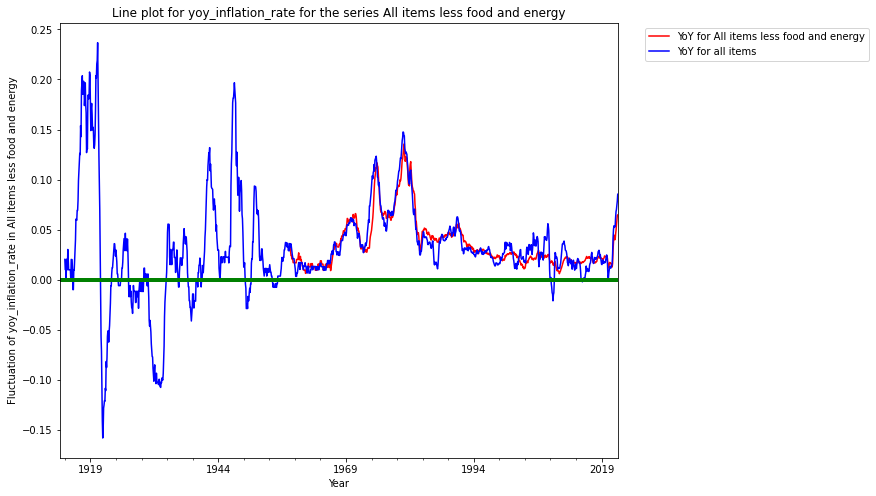

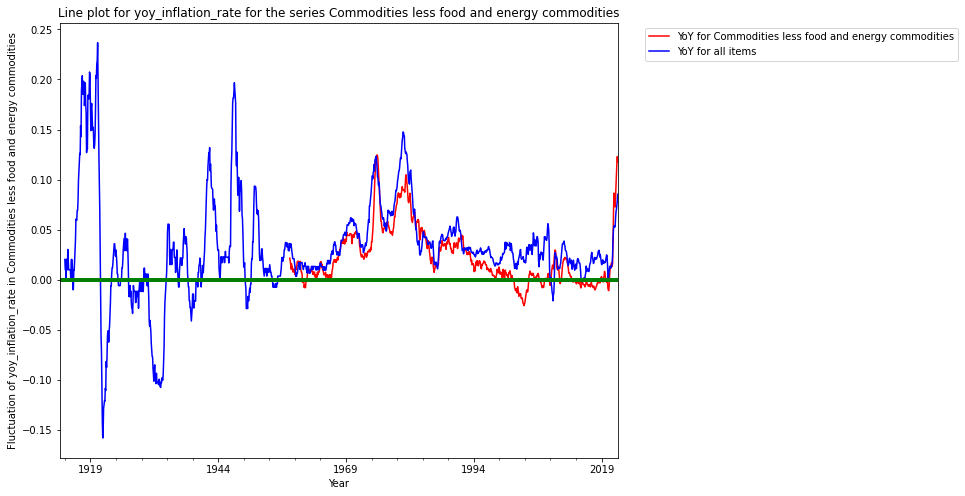

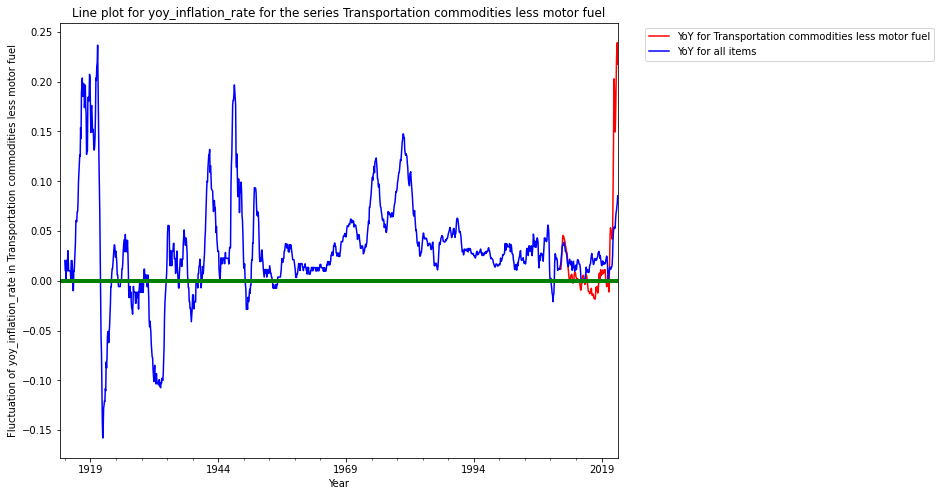

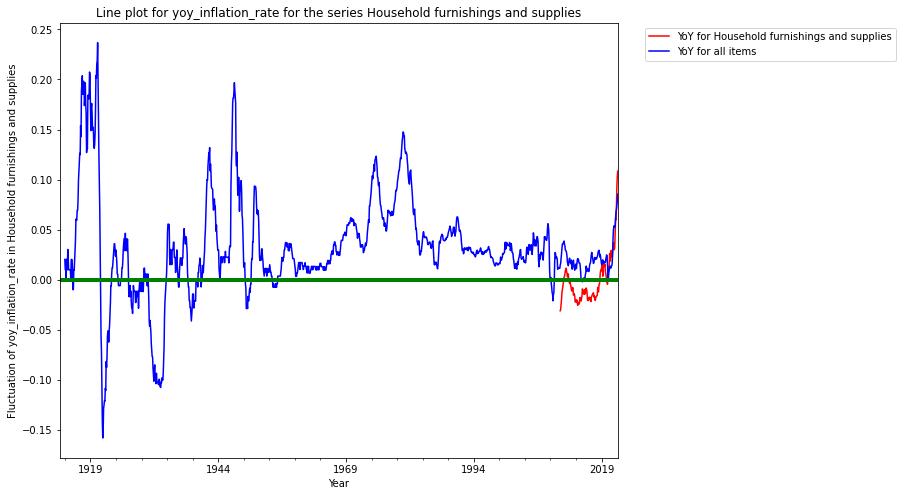

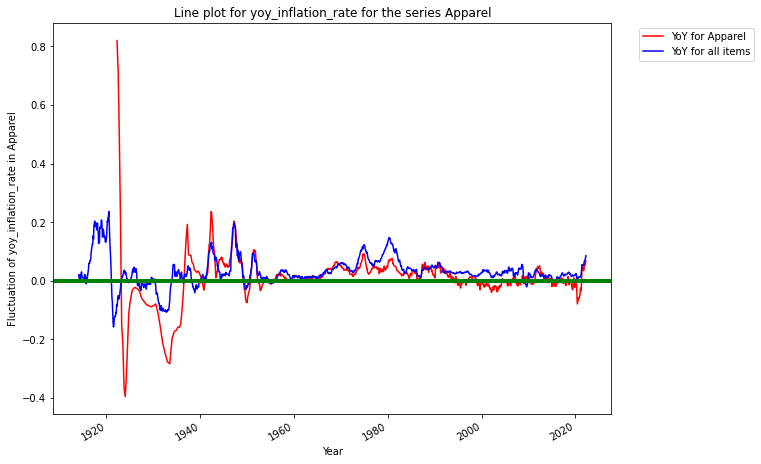

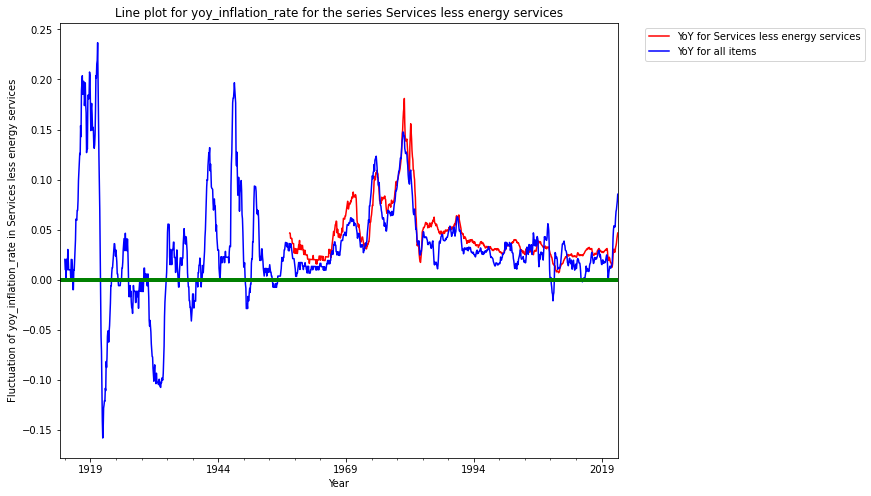

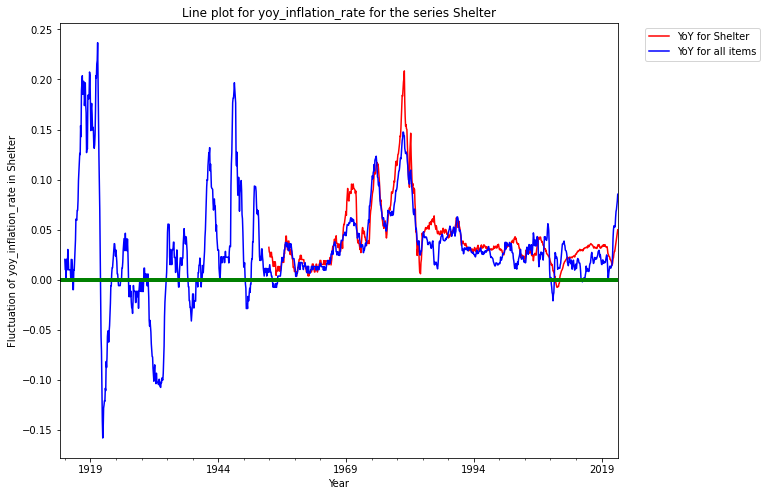

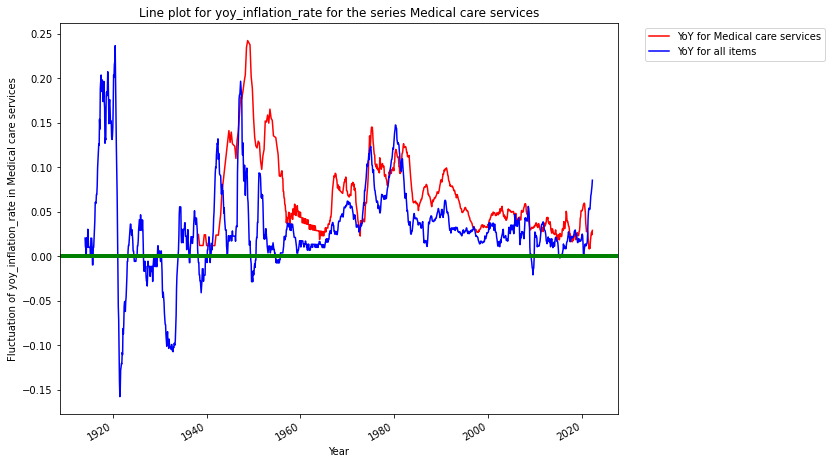

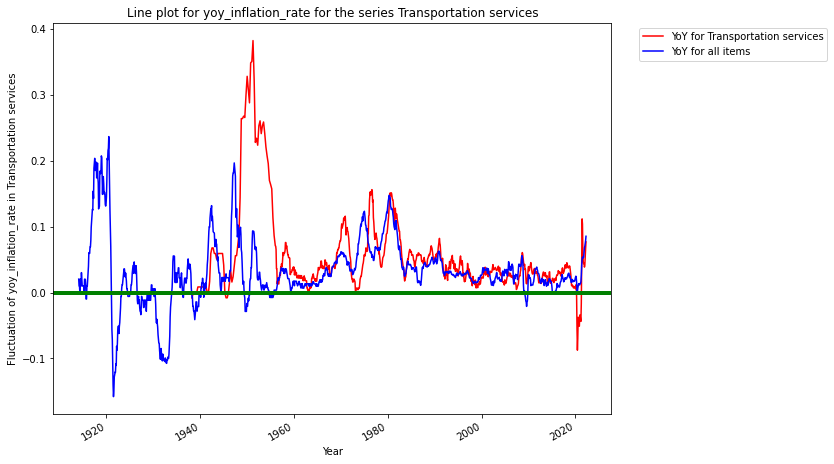

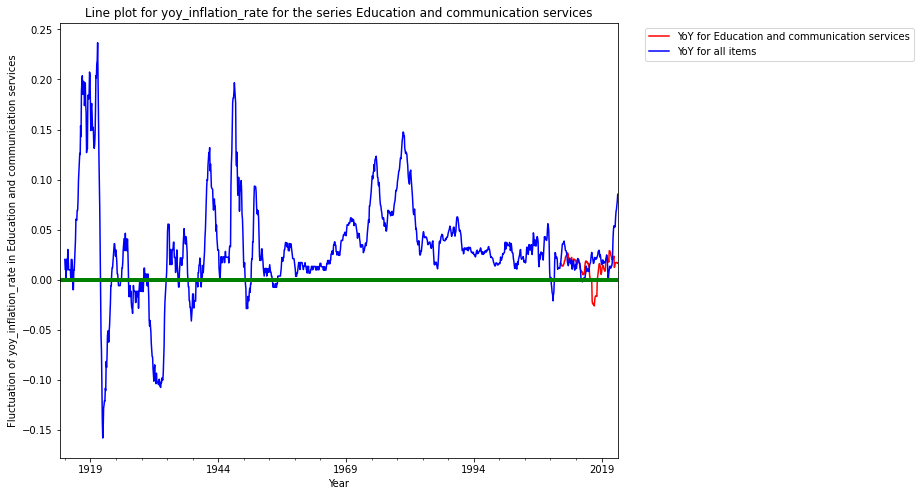

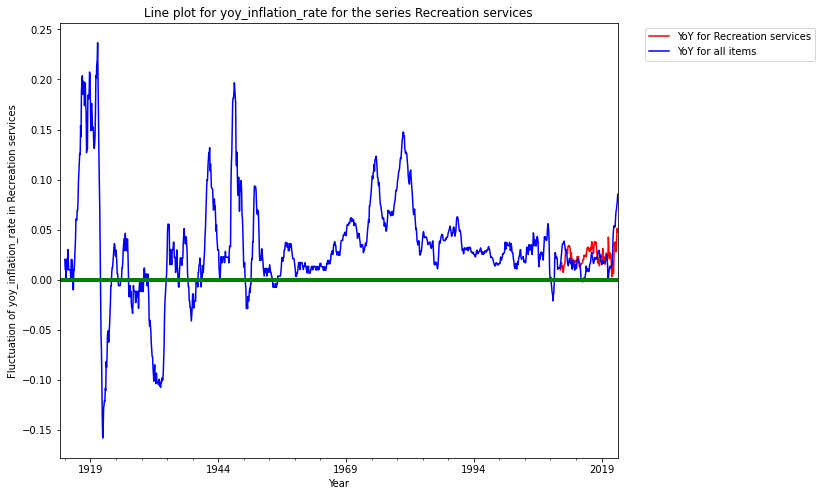

In [16]:
# Read series starting with 1.3
col_name_1 = 'yoy_inflation_rate'
col_name_2 = 'mom_inflation_rate'
file_list = os.popen('ls  1.3*').read().split("\n")
file_list = [file_name.split(".pickle")[0] for file_name in file_list if len(file_name) > 0]
file_list = sorted(file_list)
print(file_list)
viz_obj_list = []
stat_obj_list = []
viz_obj_list = [visualize_series(file) for file in file_list]
#stat_obj_list = [statistical_analysis(file) for file in file_list]
print(viz_obj_list)

#fig, ax  = plt.subplots(1,1, figsize=(10, 8))
#fig.align_labels()
#all_items['yoy_inflation_rate'].plot(ax = ax, color = 'blue', label = 'YoY for all items')
for obj in viz_obj_list:
    obj.line_plot_data(col_name = col_name_1, color = 'red', ref_df = all_items)


In [17]:
for obj in viz_obj_list:
    print(obj.get_dist_info(from_year=2000, to_year=2019))
    print("*************************************************")
    print(obj.get_dist_info(from_year=2020))
    print("*************************************************")
    print()

Series Name = All items less food and energy, Column = None, from year = 2000, to year = 2019
            value  yoy_inflation_rate  mom_inflation_rate
count  240.000000          240.000000          240.000000
mean   220.533242            0.020053            0.001655
std     24.215273            0.004462            0.001739
min    178.800000            0.006107           -0.002723
25%    198.350000            0.017276            0.000515
50%    220.493000            0.020884            0.001671
75%    239.289250            0.022805            0.002684
max    265.108000            0.029309            0.006385
None
*************************************************
Series Name = All items less food and energy, Column = None, from year = 2020, to year = None
            value  yoy_inflation_rate  mom_inflation_rate
count   27.000000           27.000000           27.000000
mean   274.175296            0.030435            0.003269
std      7.479657            0.017589            0.003118
min

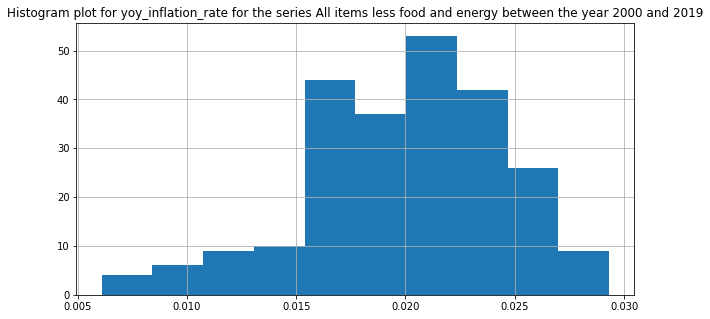

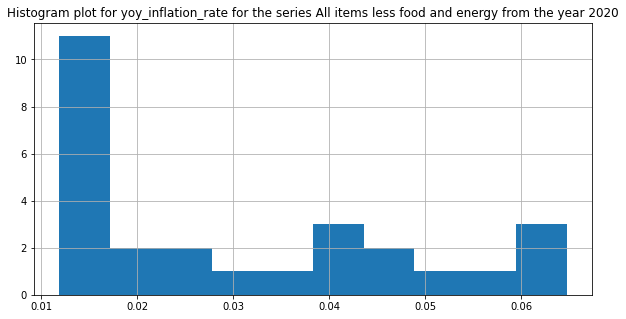

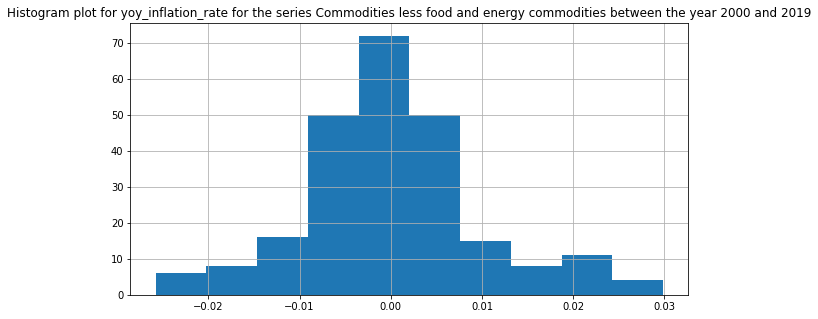

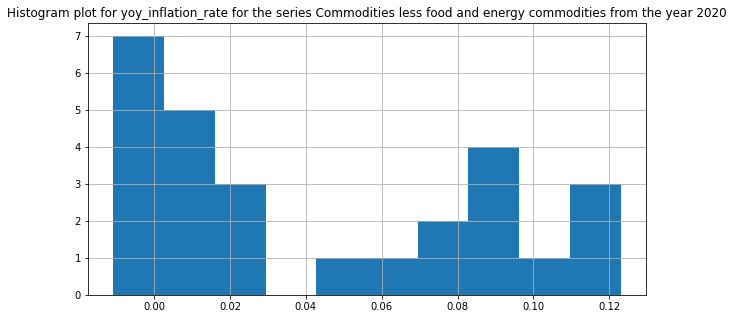

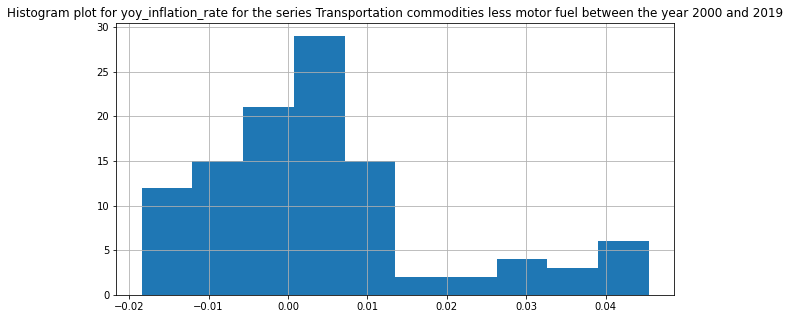

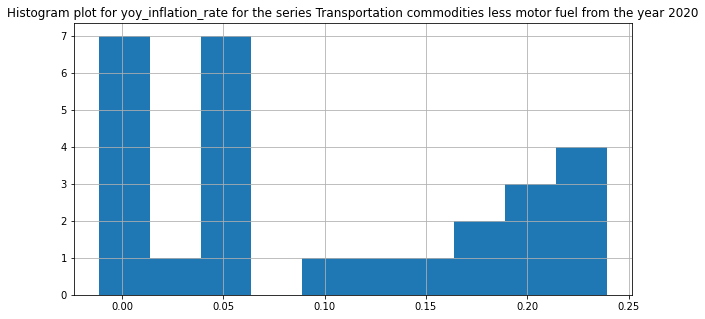

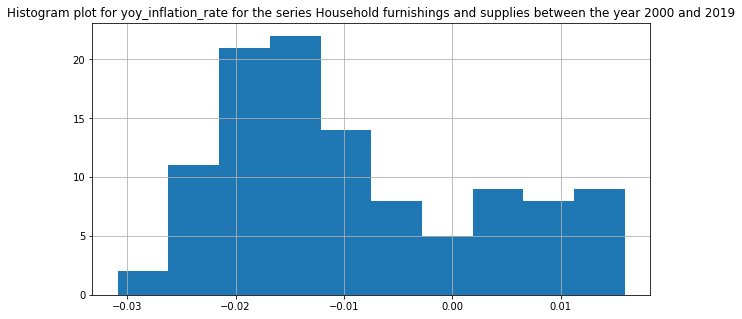

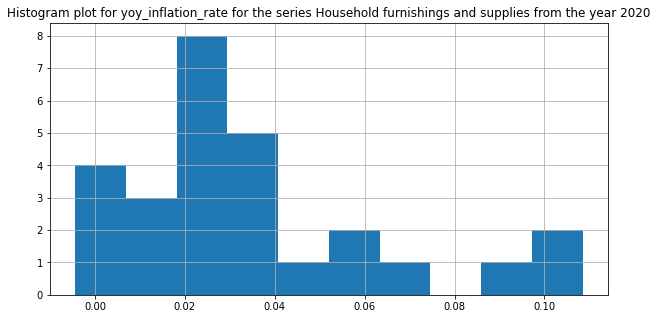

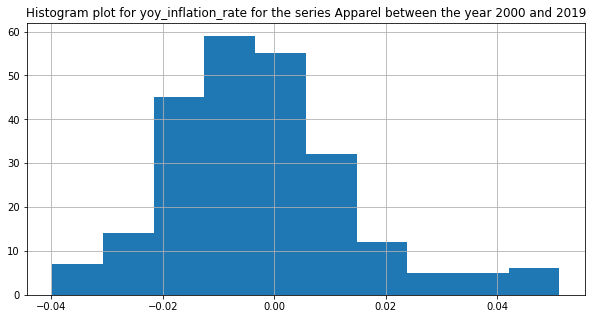

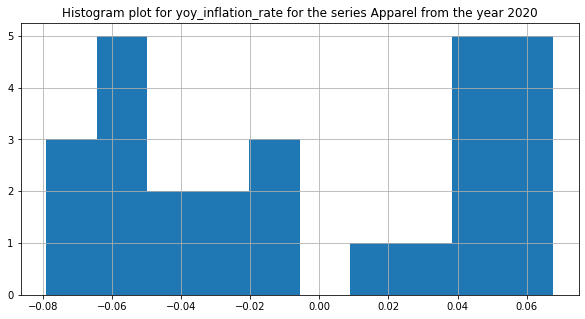

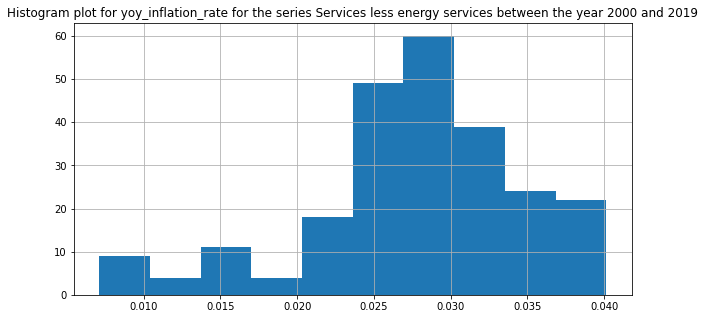

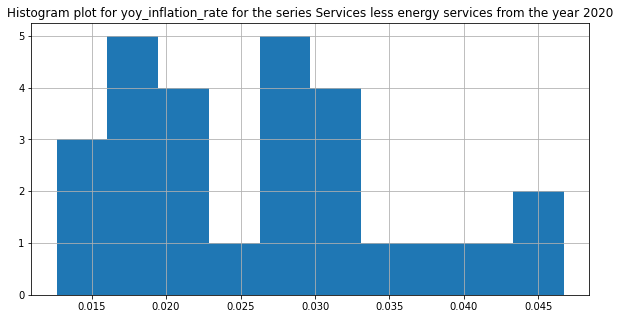

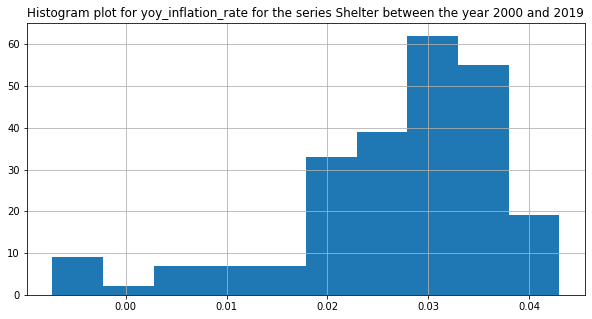

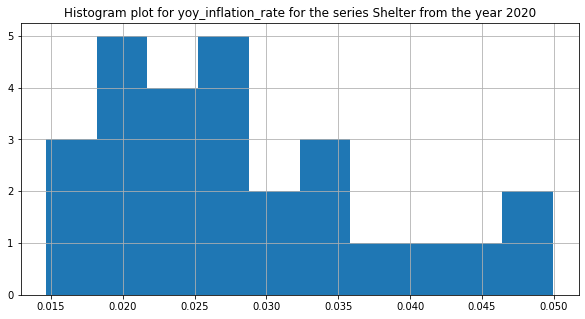

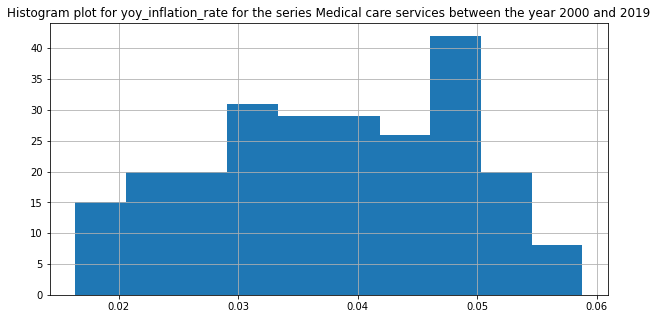

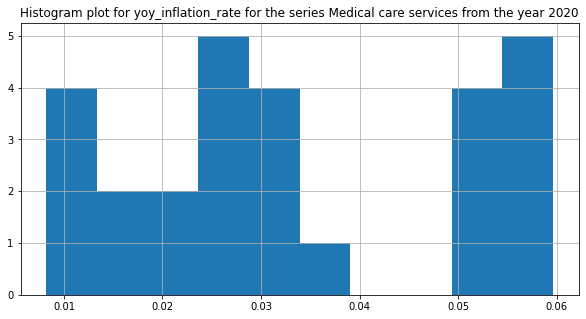

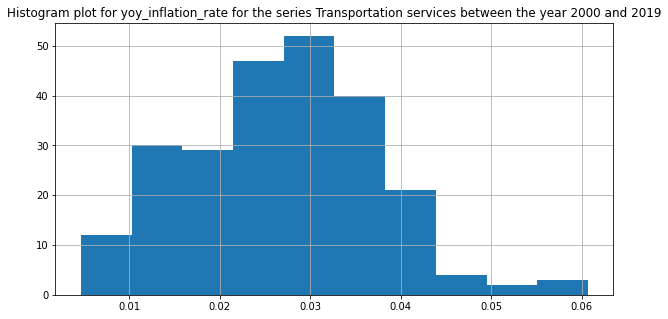

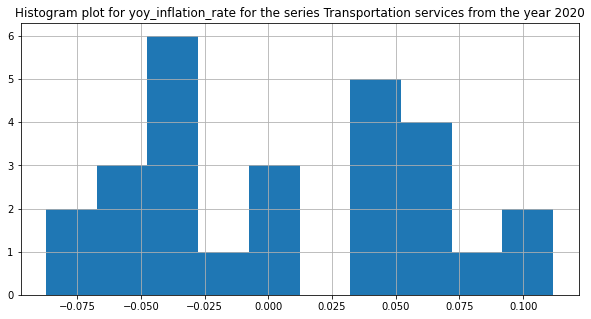

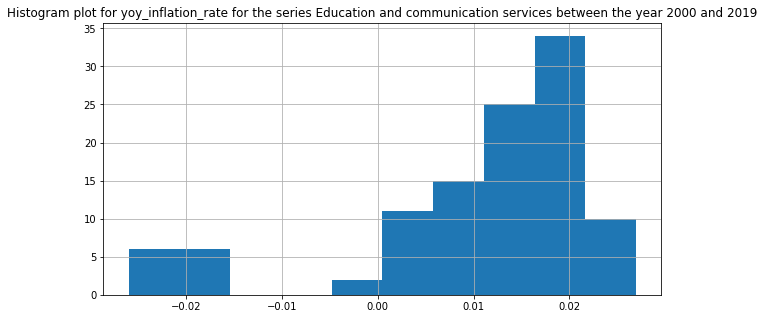

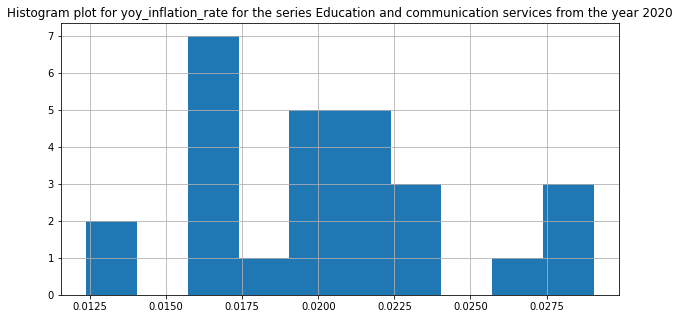

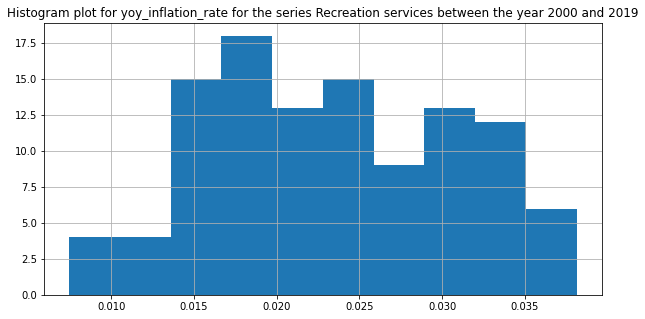

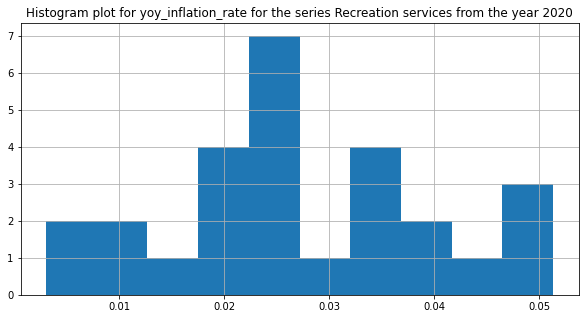

In [18]:
col_name_1 = 'yoy_inflation_rate'
col_name_2 = 'mom_inflation_rate'
for obj in viz_obj_list:
    obj.hist_plot(col_name = col_name_1, from_year = 2000, to_year = 2019)
    obj.hist_plot(col_name = col_name_1, from_year = 2020)
